# POSEIDON: Pose Estimation & Activity Recognition using GNNs

Team Members (Group 16): 
1. Chong Jun Rong Brian (A0290882U)
2. Parashara Ramesh (A0285647M)
3. Ng Wei Jie Brandon (A0184893L)

In [1]:
%load_ext autoreload
%autoreload 2

<h2><u> Table of contents </u></h2>

1. What is this project about?
<br> 1.1. Project Motivation
<br> 1.2. Project Description
<br> 1.3. Project Setup   
2. Human 3.6M Dataset
<br> 2.1. Summary of the dataset
<br> 2.2. Preparing the dataset
<br> 2.3. Visualizing poses
3. Dataset preparation
4. Models
5. Baseline 1 - SimplePose (Simple ML model without using GNNs)
6. Baseline 2 - SimplePoseGNN (Simple ML model using GNNs) 
7. Improvement 1 - SemGCN model (Reimplementation of Semantic GCN)
8. Improvement 2 - PoseGCN model (Tweaks of SemGCN)
9. Evaluation & Analysis of models
10. Creating our own custom dataset
11. Evaluation on custom dataset
12. Conclusion
13. Video presentation & Resources


<h2><u>1. What is this project about?</u></h2>
<h3><u>1.1 Project Motivation</u></h3>

Accurately predicting 3D human poses from 2D keypoints is a critical task for many applications such as motion capture and activity recognition. Traditional methods that use direct regression or lifting techniques often struggle to fully capture the complex spatial relationships between body joints. By treating the 2D pose keypoints as graphs, we can leverage the underlying connectivity between joints to improve the 3D pose estimation. Additionally, recognizing and classifying human activities from these poses is an essential task in fields like surveillance and healthcare. Therefore, this project seeks to explore how GNNs can enhance 3D pose estimation and activity recognition.

<h3><u>1.2 Project Description</h3></u>

The primary objective of this project is to predict 3D human poses from 2D pose keypoints accurately using GNNs. 
* Firstly, we will develop two baseline models: one using standard Neural Network (NN) & Convolutional Neural Network (CNN) followed by a simple GNN based model both for 3d pose estimation 
* Secondly, we will reimplement the SemGCN model, which treats the body joints of a 2D pose as nodes in a graph, with edges representing the connectivity between them. 
* Finally, we will design an improved version of the SemGCN model by exploring different GNN architectures and modifications to enhance its performance.

The secondary objective is to classify human activities based on 2D pose keypoints. We will use custom datasets to validate this task, allowing us to assess the generalization capabilities of GNN-based models for activity recognition.

<h3><u>1.3 Project Setup</u></h3>

1. Install the dependencies from requirements.txt (TODO.all to fix later)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from tqdm import tqdm
from dataloader.human36M_dataset import Human36MDataset
from models.simple_pose import SimplePose

<h2><u>2. Human 3.6M Dataset</u></h2>

<h3><u>2.1 Summary of the dataset </u></h3>

The [Human 3.6M dataset](http://vision.imar.ro/human3.6m/description.php) is a large-scale collection of 3.6 million 3D human poses captured from 11 professional actors in 17 everyday scenarios (e.g., talking, smoking, discussing). It includes synchronized video from multiple calibrated cameras, precise 3D joint positions and angles, and pixel-level body part labels. Additional data like time-of-flight range data and 3D laser scans of actors are also available.

The dataset comes with precomputed image descriptors, tools for visualizing and predicting human poses, and an evaluation set for benchmarking performance, making it a rich resource for 3D human pose estimation, action recognition, and related computer vision tasks.

<h3><u>2.2. Dataset preparation </u></h3>

Downloading the dataset from the website requires a login , therefore we will be directly using a preprocessed version of this dataset stored in google drive [here](https://drive.google.com/file/d/1JGt3j9q5A8WzUY-QKfyMVJUUvfreri-s/view?usp=drive_link).
 
Original preprocessing was done by [Martinez et al](https://github.com/una-dinosauria/3d-pose-baseline) from this repository.

The cells below go through the steps of downloading this preprocessed dataset and creating train-test files from it after some transformation. 

From section 3(Models) we will be directly using the created train-test files, therefore the cells under this section need not be executed.

<h3><u>2.3 Visualizing poses</u></h3>

In the cells below we load the 2d pose along with its corresponding 3d pose and visualize it using matplotlib.

We can observe that:
* pose is approximated using 16 joints/points in space
* Each of these joint coordinates are all normalized in the range of [-1,1] 

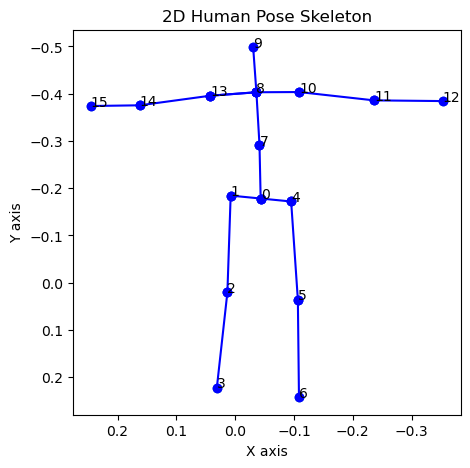

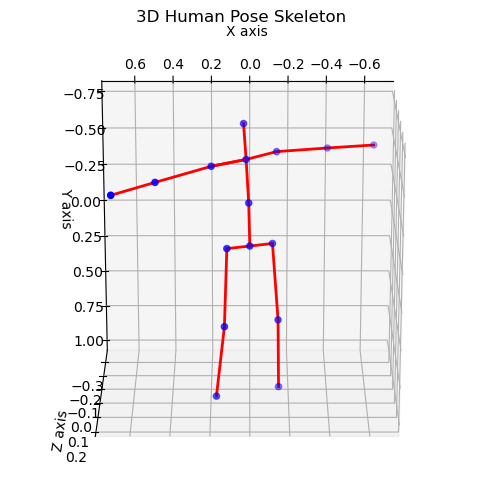

In [3]:
import numpy as np

from utils.visualization_utils import visualize_2d_pose, visualize_3d_pose

poses_2d = np.load("datasets/h36m/Processed/test_2d_poses.npy")
poses_3d = np.load("datasets/h36m/Processed/test_3d_poses.npy")

visualize_2d_pose(poses_2d[0])
visualize_3d_pose(poses_3d[0], elev=110, azim=90)

<h2><u>3. Models</u></h2>

TODO.all - write a convincing story on our approach + high level thoughts on why the following models are worth building and what we hope to gain from it

<h2><u>4. Baseline 1 - SimplePose (Simple ML model without using GNNs)</u></h2>

TODO.brian

In [4]:
# Parameters
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
NUM_EPOCHS = 200
DEVICE = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu') 

training_2d_dataset_path = os.path.join('datasets', 'h36m', 'Processed', 'train_2d_poses.npy')
training_3d_dataset_path = os.path.join('datasets', 'h36m', 'Processed', 'train_3d_poses.npy')
training_label_path  = os.path.join('datasets', 'h36m', 'Processed', 'train_actions.npy')
training_data = Human36MDataset(training_2d_dataset_path, training_3d_dataset_path, training_label_path)
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
testing_2d_dataset_path = os.path.join('datasets', 'h36m', 'Processed', 'test_2d_poses.npy')
testing_3d_dataset_path = os.path.join('datasets', 'h36m', 'Processed', 'test_3d_poses.npy')
testing_label_path  = os.path.join('datasets', 'h36m', 'Processed', 'test_actions.npy')
testing_data = Human36MDataset(testing_2d_dataset_path, testing_3d_dataset_path, testing_label_path)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)

def kaiming_weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)

TOTAL_JOINTS = training_data.get_joint_numbers()
TOTAL_ACTIONS = training_data.get_action_numbers()

# Declare Model
model = SimplePose(TOTAL_JOINTS, TOTAL_ACTIONS).to(DEVICE)
# Apply Kaiming Init on Linear Layers
model.apply(kaiming_weights_init)

print(f"Model Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Declare Optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Declare Scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96) # Value used by the original authors

# Loss Function
three_dim_pose_estimation_loss_fn = nn.MSELoss()
action_label_loss_fn = nn.CrossEntropyLoss()

# Training Loop
global_total_losses = []
global_pose_losses = []
global_action_losses = []
for epoch in tqdm(range(NUM_EPOCHS)):
    predicted_labels = None
    true_labels = None
    total_losses = []
    pose_losses = []
    action_losses = []
    for data in tqdm(train_dataloader):
        # Prepare Data
        two_dim_input_data, three_dim_output_data, action_labels= data
        two_dim_input_data = two_dim_input_data.to(DEVICE)
        three_dim_output_data = three_dim_output_data.to(DEVICE)
        action_labels = action_labels.to(DEVICE)
        # Set Gradients to 0
        optimizer.zero_grad()
        # Train Model
        predicted_3d_pose_estimations, predicted_action_labels = model(two_dim_input_data)
        # Calculate Loss
        three_dim_pose_estimation_loss = three_dim_pose_estimation_loss_fn(predicted_3d_pose_estimations, three_dim_output_data)
        action_label_loss = action_label_loss_fn(predicted_action_labels, action_labels)
        loss = three_dim_pose_estimation_loss + action_label_loss
        if epoch % 10 == 0: # Every 10 epochs, report once
            # Store Results
            total_losses.append(loss)
            pose_losses.append(three_dim_pose_estimation_loss)
            action_losses.append(action_label_loss)
            predicted_action_labels = torch.argmax(predicted_action_labels, axis=1)
            predicted_labels = predicted_action_labels if predicted_labels is None else torch.cat((predicted_labels, predicted_action_labels), axis=0)
            true_labels = action_labels if true_labels is None else torch.cat((true_labels, action_labels), axis=0)
        # Optimize Gradients and Update Learning Rate
        loss.backward()
        optimizer.step()
        scheduler.step()

    # Every 10 epochs, report once
    if epoch % 10 == 0:
        correct_predictions = (predicted_labels == true_labels).sum().item()
        accuracy = correct_predictions / predicted_labels.size(0) * 100
        total_loss = sum(total_losses) / len(train_dataloader)
        pose_loss = sum(pose_losses) / len(train_dataloader)
        action_loss = sum(action_losses) / len(train_dataloader)
        global_total_losses.append(total_loss)
        global_action_losses.append(action_loss)
        global_pose_losses.append(pose_loss)
        print(f"Epoch: {epoch} | Total Training Loss: {total_loss} | Pose Training Loss: {pose_loss} | Action Training Loss: {action_loss} | Action Train Label Accuracy: {accuracy}")
    
    if epoch % 10 == 0: # Every 10 epochs, test once
        predicted_labels = None
        true_labels = None
        total_losses = []
        pose_losses = []
        action_losses = []
        for data in tqdm(test_dataloader):
            # Prepare Data
            two_dim_input_data, three_dim_output_data, action_labels= data
            two_dim_input_data = two_dim_input_data.to(DEVICE)
            three_dim_output_data = three_dim_output_data.to(DEVICE)
            action_labels = action_labels.to(DEVICE)
            # Predict with model
            predicted_3d_pose_estimations, predicted_action_labels = model(two_dim_input_data)
            # Calculate Loss
            three_dim_pose_estimation_loss = three_dim_pose_estimation_loss_fn(predicted_3d_pose_estimations, three_dim_output_data)
            action_label_loss = action_label_loss_fn(predicted_action_labels, action_labels)
            loss = three_dim_pose_estimation_loss + action_label_loss
            # Store Results
            total_losses.append(loss)
            pose_losses.append(three_dim_pose_estimation_loss)
            action_losses.append(action_label_loss)
            predicted_action_labels = torch.argmax(predicted_action_labels, axis=1)
            predicted_labels = predicted_action_labels if predicted_labels is None else torch.cat((predicted_labels, predicted_action_labels), axis=0)
            true_labels = action_labels if true_labels is None else torch.cat((true_labels, action_labels), axis=0)
        
        # Calculate Test Accuracy
        correct_predictions = (predicted_labels == true_labels).sum().item()
        accuracy = correct_predictions / predicted_labels.size(0) * 100
        total_loss = sum(total_losses) / len(train_dataloader)
        pose_loss = sum(pose_losses) / len(train_dataloader)
        action_loss = sum(action_losses) / len(train_dataloader)
        print(f"Epoch: {epoch} | Total Testing Loss: {total_loss} | Pose Testing Loss: {pose_loss} | Action Testing Loss: {action_loss} | Action Test Label Accuracy: {accuracy}")
    
# Save model
state_dict = {
    'optimizer': optimizer.state_dict(),
    'model': model.state_dict(),
    'scheduler': scheduler.state_dict(),
}
weight_save_path = os.path.join('weights', 'linear_baseline_model')
if not os.path.exists(weight_save_path):
    os.makedirs(weight_save_path)

torch.save(state_dict, os.path.join(weight_save_path, 'weights.pth'))

Model Parameters: 4304959


  0%|          | 0/200 [00:30<?, ?it/s]


KeyboardInterrupt: 

<h2><u>5. Baseline 2 - SimplePoseGNN (Simple ML model using GNNs)</u></h2>

TODO.brandon

<h2><u>6. Improvement 1 - SemGCN model (Reimplementation of Semantic GCN)</u></h2>

TODO.parash


<h2><u>7. Improvement 2 - PoseGCN model (Tweaks of SemGCN)</u></h2>

TODO.all

<h2><u>8. Evaluation & Analysis of models<u></h2>

<h2><u>9. Creating our own custom dataset</u></h2>

<h2><u>10. Evaluation on custom dataset</u></h2>

<h2><u>11. Conclusion</u></h2>

<h2><u>12. Video presentation & Resources</u></h2>